In [1]:
pip install pandas numpy matplotlib seaborn plotly emoji nltk pillow wordcloud scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

import pickle

In [3]:
df=pd.read_csv("E:/cyberbullying_tweets.csv")

## Initial Review

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
df.tail()

,tweet_text,cyberbullying_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


## Checking Missing Values

In [7]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [8]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

## Cleaning and Data Processing

In [9]:
df=df.rename(columns={'tweet_text':'text','cyberbullying_type':'sentiment'})

In [10]:
df.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [11]:
df['sentiment_encoded']=df['sentiment'].replace({
    'religion':1,
    'age':2,
    'ethnicity':3,
    'gender':4,
    'other_cyberbullying':5,
    'not_cyberbullying':6
})

In [12]:
df.tail()

,text,sentiment,sentiment_encoded
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,3
47688,Turner did not withhold his disappointment. Tu...,ethnicity,3
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,3
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,3
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity,3


## nltk.download('stopwords')

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
import nltk

nltk.download('stopwords')  # Download the stopwords corpus
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing of text

In [16]:
# Function to remove emojis

def strip_emoji(text):
    return emoji.replace_emoji(text,replace="") 

In [17]:
# Function to convert text to lowercase, remove (unwanted characters)

def strip_all_entities(text):
    
    text=text.replace('\r','').replace('\n','').lower()
    text=re.sub(r"(?:\@|https?|-\://)\S+",'',text)
    text=re.sub(r"[^\x00-\x7f]",r'',text)
    text=re.sub('[0-9]+','',text)
    
    stopchars=string.punctuation
    table=str.maketrans('','',stopchars)
    text=text.translate(table)
    
    text=[word for word in text.split() if word not in stop_words]
    text=' '.join(text)
    
    return text

## Function to remove contractions

In [18]:
def decontract(text):
    
    text=re.sub(r"cant\'t'","can not",text)
    text=re.sub(r"n\'t","not",text)
    text=re.sub(r"\'re","are",text)
    text=re.sub(r"\'s","is",text)
    text=re.sub(r"\'d","would",text)
    text=re.sub(r"\'ll","will",text)
    text=re.sub(r"\'t","not",text)
    text=re.sub(r"\'ve","have",text)
    text=re.sub(r"\'m","am",text)
    
    return text

In [25]:
#function to clean hashtags

def clean_hashtags(tweet):
    
    new_tweet=" ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?:\s+#[\w-]+)*\s*$', tweet))
    new_tweet2=" ".join(word.strip() for word in re.split('#|_', new_tweet))
    
    return new_tweet2

In [26]:
##function to filter special characters

def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

In [31]:
# Removing sequences, and applying stemming

def remove_mult_spaces(text):
    return re.sub("\s\s+"," ", text)

def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

In [32]:
#Using all the functions

def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    text = lemmatize(text)
    return text

In [33]:
print(df.columns)


Index(['text', 'sentiment', 'sentiment_encoded'], dtype='object')


In [35]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
df['cleaned_text'] = df['text'].apply(preprocess)
df.head()

,text,sentiment,sentiment_encoded,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...


## Dealing with duplicates

In [38]:
df['cleaned_text'].duplicated().sum()

2988

In [39]:
df.drop_duplicates('cleaned_text',inplace=True)

## Tokenization

In [40]:
df['tweet_list']=df['cleaned_text'].apply(word_tokenize)

df.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like..."


## EDA

In [41]:
# Checking the lengths of various tweet text
text_len = []
for text in df.tweet_list:
    tweet_len = len(text)
    text_len.append(tweet_len)
df['text_len']=text_len

<function matplotlib.pyplot.show(close=None, block=None)>

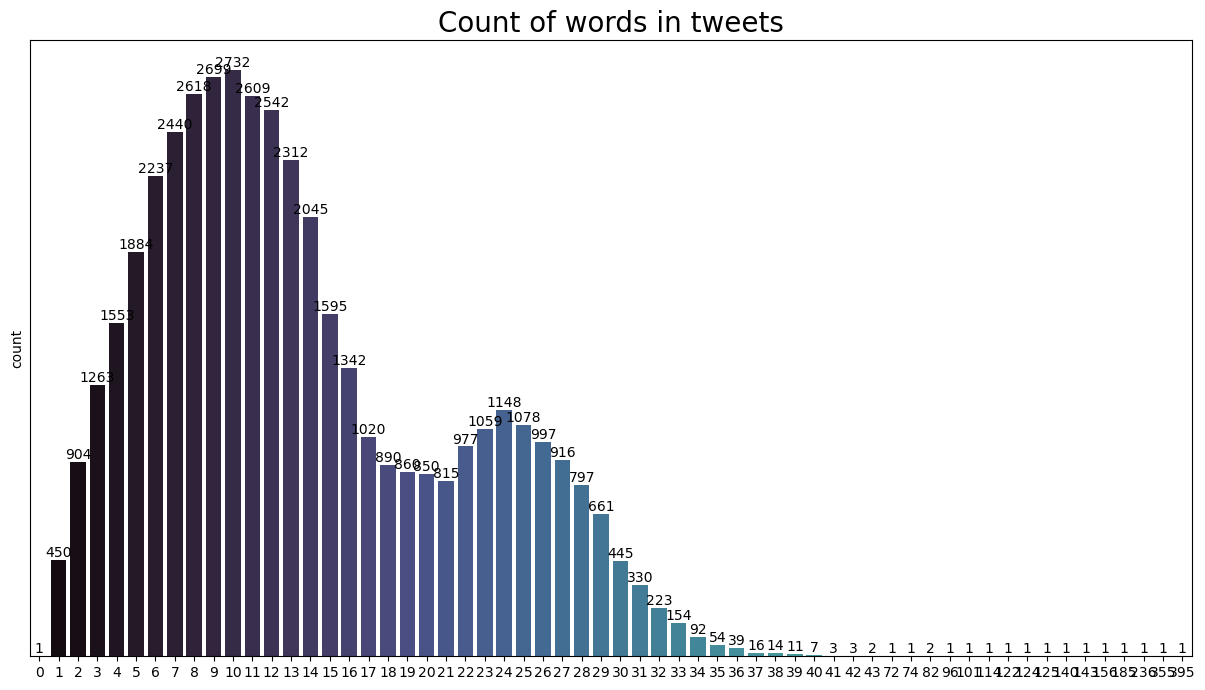

In [43]:
plt.figure(figsize=(15,8))
ax=sns.countplot(x='text_len', data=df, palette='mako')
plt.title('Count of words in tweets', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show

## Removing text without words


In [44]:
df = df[df['text_len']!=0]

In [45]:
df.shape

(44703, 6)

## Function to create word clout

In [47]:
def plot_wordcloud(cyberbullying_type):
    string = ""
    for i in df[df.sentiment == cyberbullying_type].cleaned_text.values:
        string = string + " " + i.strip()
        
    wordcloud = WordCloud(background_color = 'white', max_words=2000, max_font_size=256,
                          random_state=42).generate(string)
    
    #plot wordclout image
    plt.figure(figsize = (8,8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(cyberbullying_type)
    plt.show()
    del string

## Splitting data based in sentiments for EDA

In [48]:
not_cyberbullying_type = df[df['sentiment']=='not_cyberbullying']
gender_type = df[df['sentiment']=='gender']
religion_type = df[df['sentiment']=='religion']
other_cyberbullying_type = df[df['sentiment']=='other_cyberbullying']
age_type = df[df['sentiment']=='age']
ethnicity_type = df[df['sentiment']=='ethnicity']

In [49]:
#EDA

In [50]:
gender = Counter([item for sublist in gender_type['tweet_list'] for item in sublist])
top20_gender = pd.DataFrame(gender.most_common(20))
top20_gender.columns = ['Top Words', 'Count']
top20_gender.head(20)

,Top Words,Count
0,joke,5180
1,rape,4072
2,gay,3851
3,call,1401
4,make,1286
5,rt,1219
6,bitch,1145
7,woman,1110
8,femal,1107
9,like,978


Text(0.5, 1.0, 'Top 20 words on Gender based Cyberbullying')

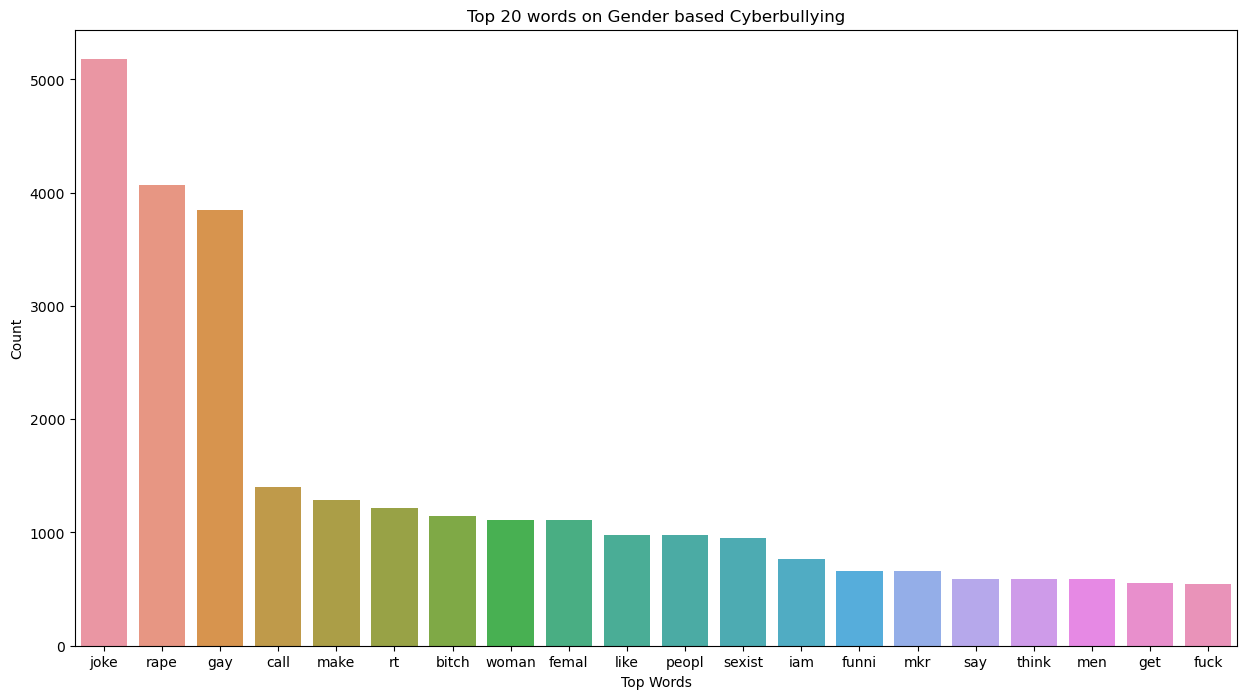

In [52]:
fig=plt.figure(figsize=(15,8))
sns.barplot(data=top20_gender, y="Count", x="Top Words")
plt.title("Top 20 words on Gender based Cyberbullying")

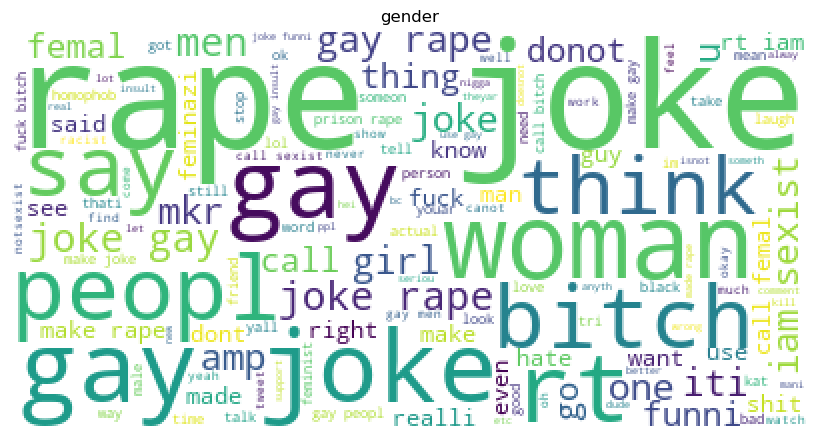

In [53]:
plot_wordcloud('gender')

In [54]:
religion = Counter([item for sublist in religion_type['tweet_list'] for item in sublist])
top20_religion = pd.DataFrame(religion.most_common(20))
top20_religion.columns = ['Top Words', 'Count']
top20_religion.style.background_gradient(cmap='Greens')

,Top Words,Count
0,muslim,4600
1,idiot,3067
2,islam,2426
3,christian,2123
4,u,1919
5,terrorist,1374
6,right,1288
7,like,1276
8,support,1250
9,woman,1225


Text(0.5, 1.0, 'Top 20 words on religion based Cyberbullying')

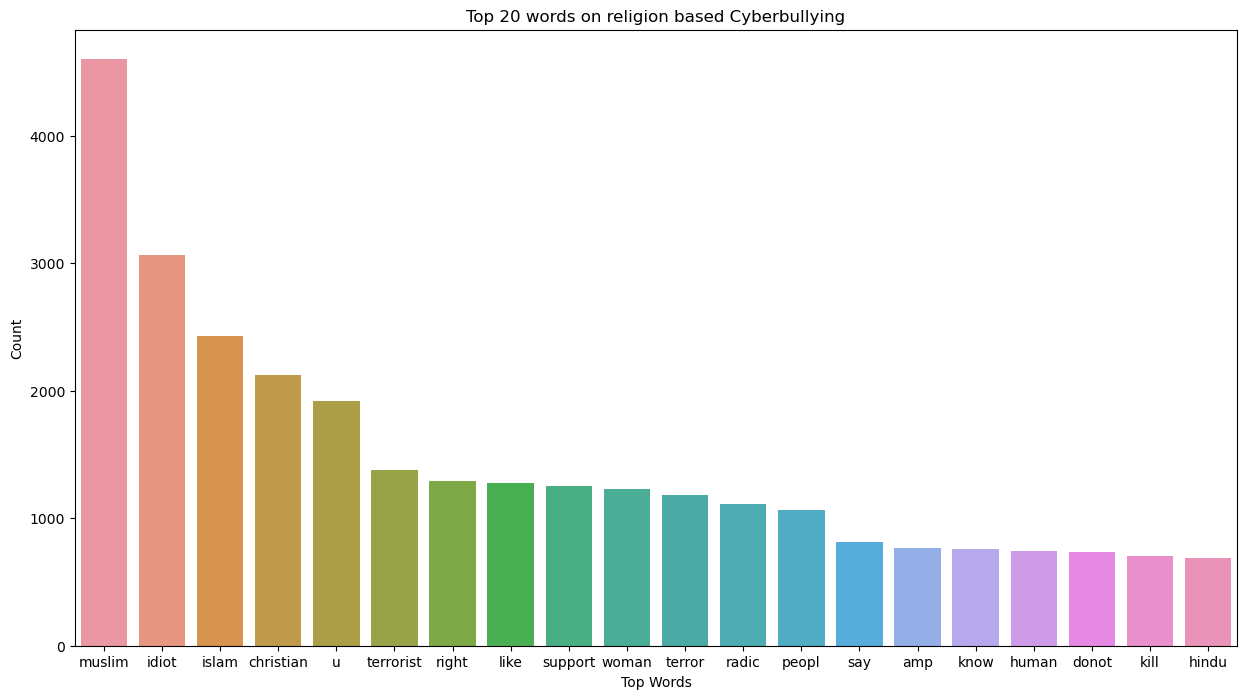

In [56]:
fig=plt.figure(figsize=(15,8))
sns.barplot(data=top20_religion, y="Count", x="Top Words")
plt.title("Top 20 words on religion based Cyberbullying")

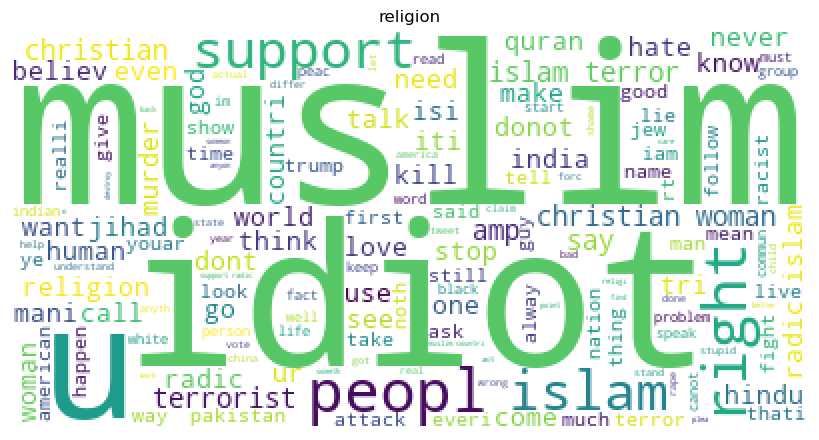

In [57]:
plot_wordcloud('religion')

In [58]:
age = Counter([item for sublist in age_type['tweet_list'] for item in sublist])
top20_age = pd.DataFrame(age.most_common(20))
top20_age.columns = ['Top Words', 'Count']
top20_age.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,8895
1,school,8423
2,high,4861
3,girl,4605
4,like,2080
5,get,1052
6,one,1040
7,peopl,928
8,got,842
9,kid,805


Text(0.5, 1.0, 'Top 20 words on age based Cyberbullying')

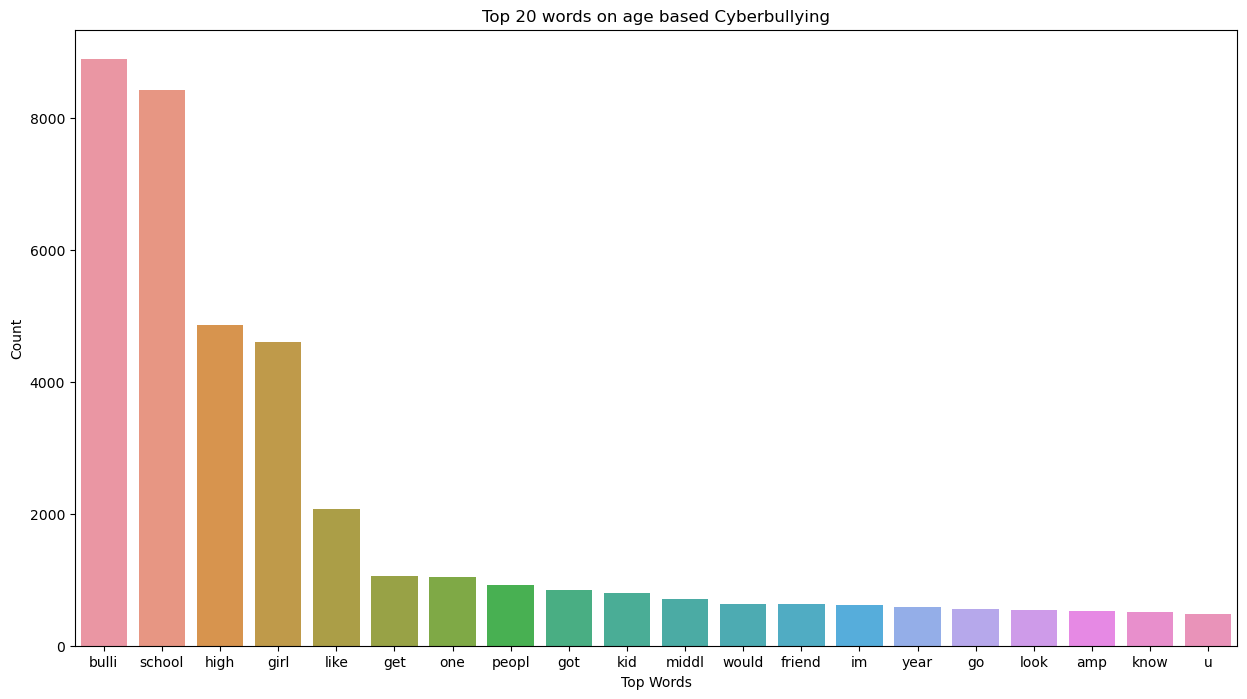

In [60]:
fig=plt.figure(figsize=(15,8))
sns.barplot(data=top20_age, y="Count", x="Top Words")
plt.title("Top 20 words on age based Cyberbullying")

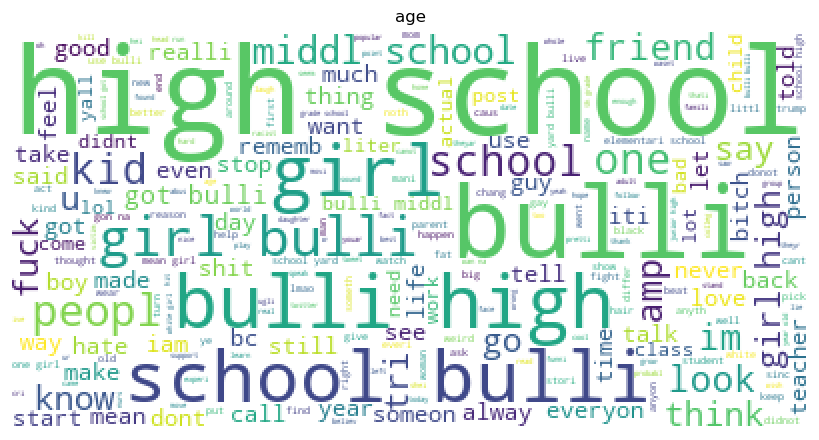

In [61]:
plot_wordcloud('age')

In [62]:
ethnicity = Counter([item for sublist in ethnicity_type['tweet_list'] for item in sublist])
top20_ethnicity = pd.DataFrame(ethnicity.most_common(20))
top20_ethnicity.columns = ['Top Words', 'Count']
top20_ethnicity.style.background_gradient(cmap='Greens')

,Top Words,Count
0,fuck,5890
1,nigger,5454
2,dumb,5006
3,as,2241
4,black,2132
5,u,2099
6,white,1557
7,call,1381
8,peopl,1179
9,rt,1163


Text(0.5, 1.0, 'Top 20 words on ethnicity based Cyberbullying')

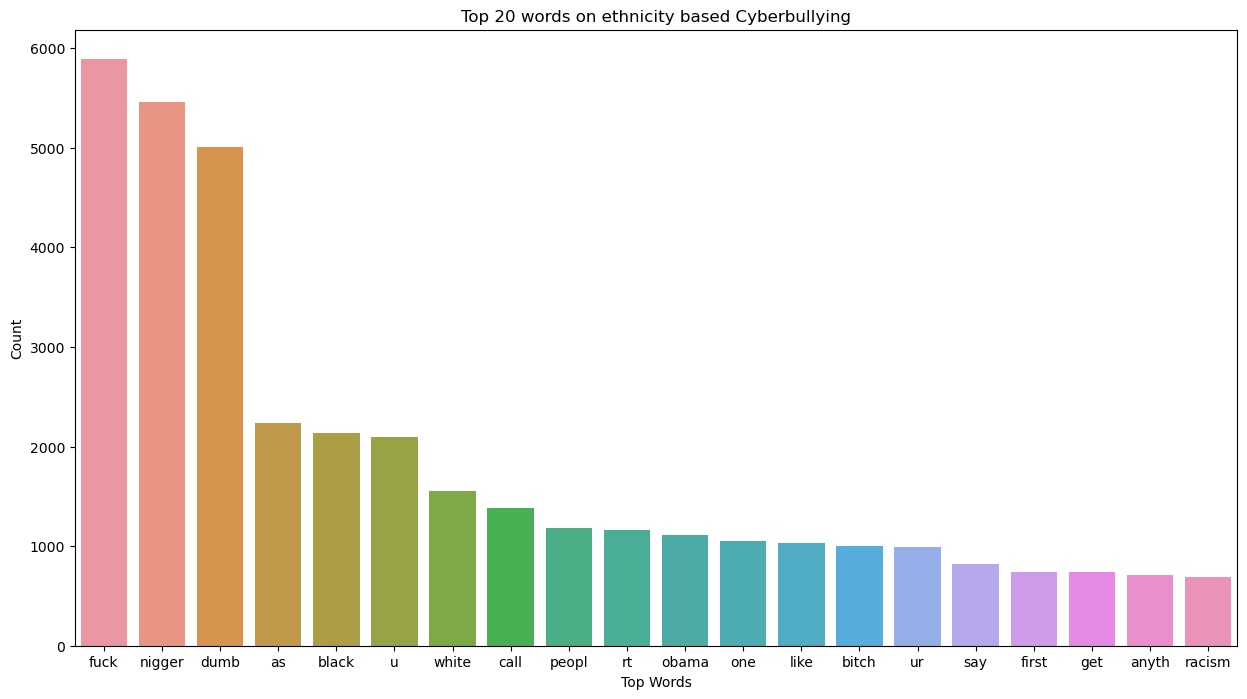

In [63]:
fig=plt.figure(figsize=(15,8))
sns.barplot(data=top20_ethnicity, y="Count", x="Top Words")
plt.title("Top 20 words on ethnicity based Cyberbullying")

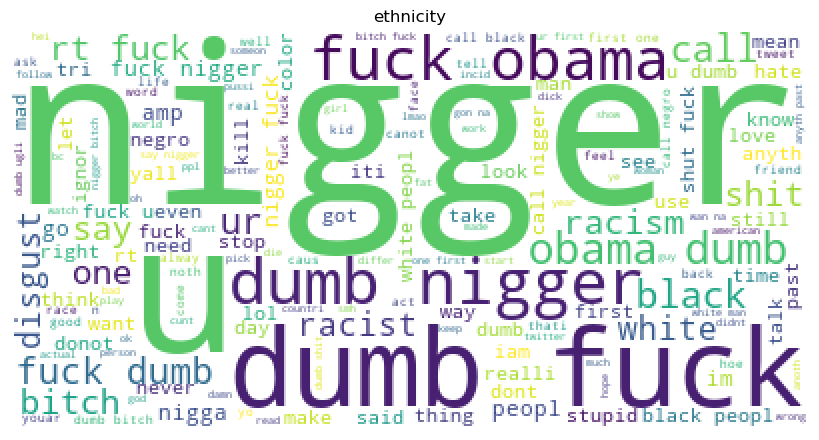

In [64]:
plot_wordcloud('ethnicity')

In [65]:
other_cyberbullying = Counter([item for sublist in other_cyberbullying_type['tweet_list'] for item in sublist])
top20_other_cyberbullying = pd.DataFrame(other_cyberbullying.most_common(20))
top20_other_cyberbullying.columns = ['Top Words', 'Count']
top20_other_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,882
1,rt,718
2,iam,526
3,fuck,509
4,like,423
5,get,393
6,iti,383
7,peopl,349
8,donot,344
9,go,277


Text(0.5, 1.0, 'Top 20 words in other cyberbullying ')

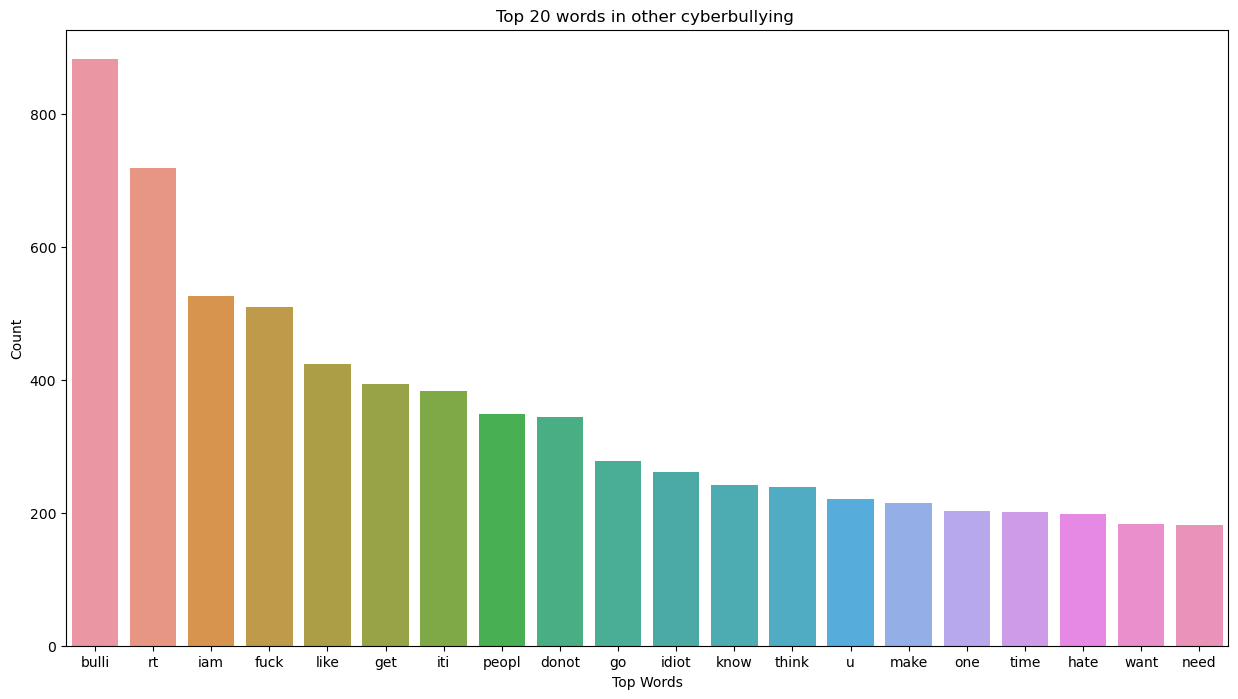

In [66]:
fig=plt.figure(figsize=(15,8))
sns.barplot(data=top20_other_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in other cyberbullying ")

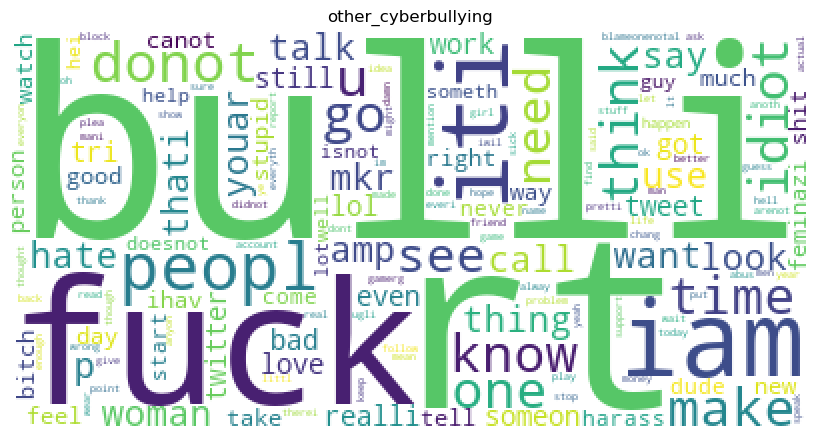

In [67]:
plot_wordcloud('other_cyberbullying')

In [68]:
#Tweets with no cyberbullying

In [69]:
not_cyberbullying = Counter([item for sublist in not_cyberbullying_type['tweet_list'] for item in sublist])
top20_not_cyberbullying = pd.DataFrame(not_cyberbullying.most_common(20))
top20_not_cyberbullying.columns = ['Top Words', 'Count']
top20_not_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,mkr,1666
1,bulli,1095
2,rt,781
3,like,424
4,get,420
5,iam,413
6,go,395
7,school,374
8,donot,338
9,iti,333


Text(0.5, 1.0, 'Top 20 words in Not cyberbullying ')

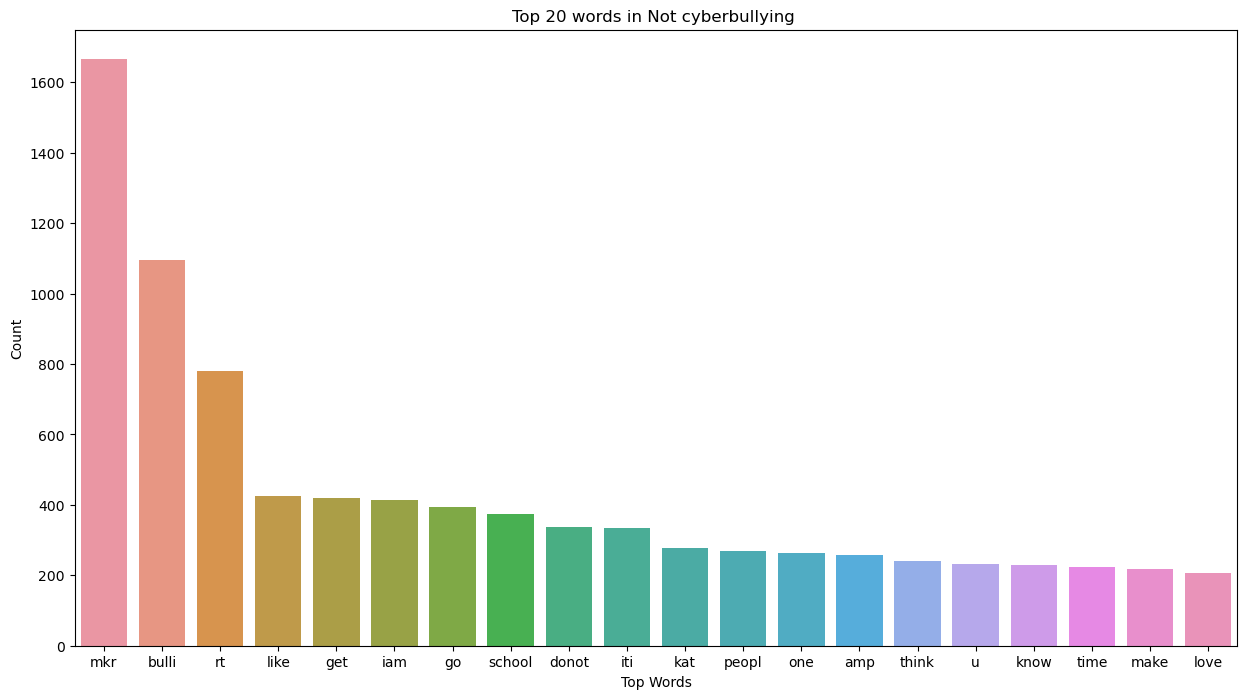

In [70]:
fig=plt.figure(figsize=(15,8))
sns.barplot(data=top20_not_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Not cyberbullying ")

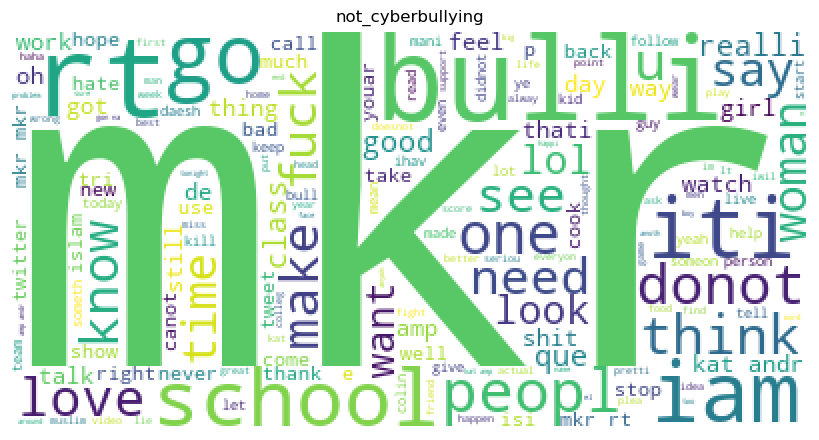

In [71]:
plot_wordcloud('not_cyberbullying')

In [72]:
df.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]",5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya...",11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]",5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d...",9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like...",8


In [73]:
sentiments = ["religion","age", "ethnicity", "gender", "other_cyberbullying", "not_cyberbulling"]

## Modeling

In [75]:
# splitting data in train and test

In [77]:
X,Y = df['cleaned_text'],df['sentiment_encoded']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(31292,) (31292,) (13411,) (13411,)


In [80]:
#tf-idf vectorizer

In [83]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)
print(X_train_tf.shape)
print(X_test_tf.shape)

(31292, 29697)
(13411, 29697)


In [84]:
#Trying different models

In [85]:
#Logistics

log_reg = LogisticRegression()

In [86]:
log_cv_score = cross_val_score(log_reg, X_train_tf, y_train, cv=5, scoring='f1_macro', n_jobs=-1)

In [87]:
mean_log_cv = np.mean(log_cv_score)
mean_log_cv

0.8245720194622652

In [88]:
#Supporting vector SVM

In [89]:
lin_svc = LinearSVC()

In [90]:
lin_svc_cv_score = cross_val_score(lin_svc, X_train_tf, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score)
mean_lin_svc_cv

0.8234144299710039

In [91]:
#Naive Bayes Classifier

In [92]:
multiNB = MultinomialNB()

In [93]:
multiNB_cv_score = cross_val_score(multiNB, X_train_tf, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
mean_multiNB_cv = np.mean(multiNB_cv_score)
mean_multiNB_cv

0.6749396898588003

In [94]:
#Decsision Tree classifier

In [98]:
dtree = DecisionTreeClassifier()

In [99]:
dtree_cv_score = cross_val_score(dtree, X_train_tf, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
mean_dtree_cv = np.mean(dtree_cv_score)
mean_dtree_cv

0.8094306521356612

In [100]:
#Random forest classifier

In [101]:
rand_forest = RandomForestClassifier()

In [103]:
rand_forest_cv_score = cross_val_score(rand_forest, X_train_tf, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
mean_rand_forest_cv = np.mean(rand_forest_cv_score)
mean_rand_forest_cv

KeyboardInterrupt: 

In [ ]:
#ada boost classifier

In [ ]:
adab=AdaBoostClassifier()

In [ ]:
adab_cv_score = cross_val_score(adab, X_train_tf, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
mean_adab_cv = np.mean(dtree_cv_score)
mean_adab_cv

In [104]:
#Tuning SVC

In [105]:
svc1 = LinearSVC()
param_grid = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10],
             'loss':['hinge','squared_hinge'],
             'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(X_train_tf,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='f1_macro')

In [106]:
grid_search.best_estimator_

LinearSVC(C=1, loss='hinge')

In [107]:
grid_search.best_score_

0.8268251871719855

In [109]:
#Evaluation

lin_svc.fit(X_train_tf, y_train)
y_pred = lin_svc.predict(X_test_tf)

In [115]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers!")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabels('Truth')
    plt.xlabels('Prediction')

AttributeError: module 'matplotlib.pyplot' has no attribute 'ylabels'

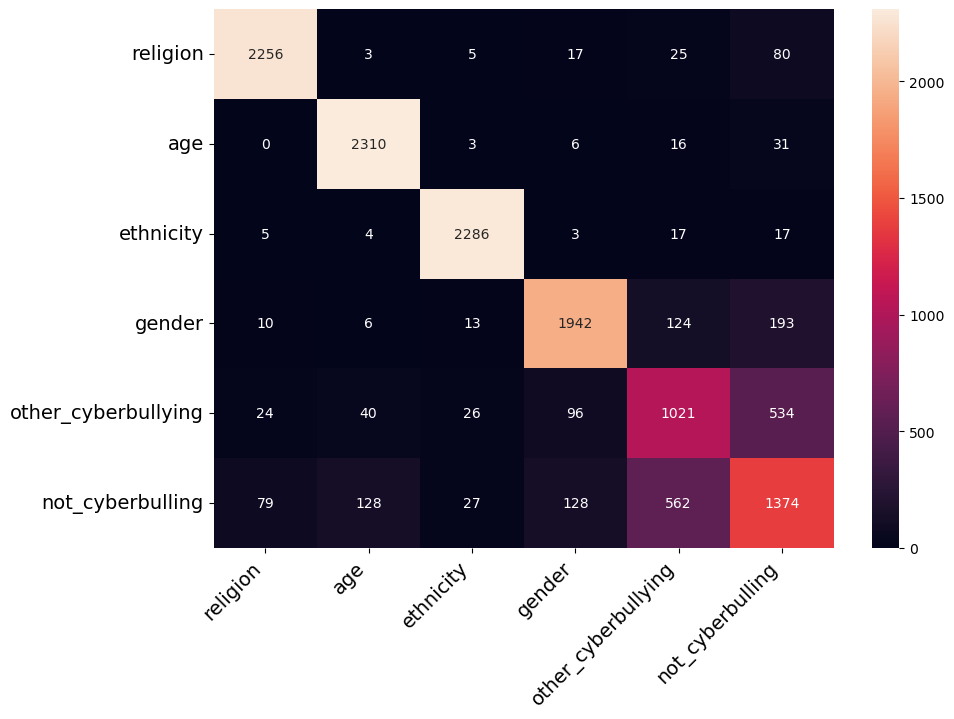

In [116]:
cm = confusion_matrix(y_test, y_pred)
print_confusion_matrix(cm,sentiments)

In [117]:
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=sentiments))

Classification Report:
                      precision    recall  f1-score   support

           religion       0.95      0.95      0.95      2386
                age       0.93      0.98      0.95      2366
          ethnicity       0.97      0.98      0.97      2332
             gender       0.89      0.85      0.87      2288
other_cyberbullying       0.58      0.59      0.58      1741
   not_cyberbulling       0.62      0.60      0.61      2298

           accuracy                           0.83     13411
          macro avg       0.82      0.82      0.82     13411
       weighted avg       0.83      0.83      0.83     13411

